# Capstone (3/3) - Netflix Recommender (TensorFlow)

## 1. Import Libraries

In [1]:
import numpy as np 
import pandas as pd
import matplotlib.pyplot as plt

from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split

import tensorflow as tf
from tensorflow import keras
from keras.models import Model
from keras.layers import Input, Reshape, Dot, Concatenate, Dense, Dropout
from keras.layers.embeddings import Embedding
from keras.optimizers import Adam
from keras.regularizers import l2

## 2. Load File

In [2]:
# load file
df =  pd.read_csv('2005-d4.csv')
movie_df = pd.read_csv('2005-d41kMT.csv')

# Using info to check the shape, column names and type of df
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5116704 entries, 0 to 5116703
Data columns (total 6 columns):
 #   Column        Dtype 
---  ------        ----- 
 0   movie_id      int64 
 1   user_id       int64 
 2   rating        int64 
 3   date          object
 4   release_year  int64 
 5   movie_title   object
dtypes: int64(4), object(2)
memory usage: 234.2+ MB


## 3. Simple EDA and Configurations

In [3]:
# Copy df as a new df
new_df = df.copy(deep=True)

# use label encoder for movie id and user id, such that they will be in running sequence
le = LabelEncoder()
new_df['user'] = le.fit_transform(new_df['user_id'].values)
new_df['movie'] = le.fit_transform(new_df['movie_id'].values)

n_users = new_df['user'].nunique()
n_movies = new_df['movie'].nunique()

new_df

,movie_id,user_id,rating,date,release_year,movie_title,user,movie
0,6105,2606550,2,2005-08-21,2000,Paranoid,342296,6006
1,1865,482356,4,2005-11-09,2004,Eternal Sunshine of the Spotless Mind,63573,1833
2,4996,49106,4,2005-06-18,2000,Gone in 60 Seconds,6417,4913
3,1307,1090820,3,2005-07-17,2003,S.W.A.T.,143469,1285
4,9628,502622,3,2005-09-02,1983,Star Wars: Episode VI: Return of the Jedi,66280,9471
...,...,...,...,...,...,...,...,...
5116699,1865,1500751,5,2005-09-25,2004,Eternal Sunshine of the Spotless Mind,197136,1833
5116700,7193,1646303,5,2005-10-14,1987,The Princess Bride,216403,7073
5116701,1073,129941,4,2005-06-27,2005,Coach Carter,17002,1053
5116702,2782,104920,4,2005-11-17,1995,Braveheart,13663,2738


## 4. Split Data into Train, Test and Validation Sets

In [4]:
#Set the X and y variables
X = new_df[['user', 'movie']].values
y = new_df['rating'].values

# Split train and test data (for test model performance at last)
X_training, X_test, y_training, y_test = train_test_split(X, y, test_size=0.1)

# Split train and validation data (to monitor model performance in training)
X_train, X_val, y_train, y_val = train_test_split(X_training, y_training, test_size=0.1)

# Set the embedding dimension d of Matrix factorization
e_dimension = 50

X_train_array = [X_train[:, 0], X_train[:, 1]]
X_val_array = [X_val[:, 0], X_val[:, 1]]
X_test_array = [X_test[:, 0], X_test[:, 1]]

## 5. Create the Model

In [5]:
# Build user embedding matrix
user = Input(shape=(1,))
u = Embedding(n_users, e_dimension, embeddings_initializer='he_normal',
              embeddings_regularizer=l2(1e-6))(user)
u = Reshape((e_dimension,))(u)

# Build movie embedding matrix
movie = Input(shape=(1,))
m = Embedding(n_movies, e_dimension, embeddings_initializer='he_normal',
              embeddings_regularizer=l2(1e-6))(movie)
m = Reshape((e_dimension,))(m)


x = Dot(axes=1)([u, m])


# Build last deep learning layers 
x = Dense(128, activation='relu')(x)
x = Dropout(0.2)(x)
x = Dense(1)(x)

model = Model(inputs=[user, movie], outputs=x)
model.compile(loss='mean_squared_error', optimizer=Adam(lr=0.001), metrics=[tf.keras.metrics.RootMeanSquaredError()])

# Set up for early stop if the validation loss stop improving for more than 1 epoch
callbacks_list = [keras.callbacks.EarlyStopping(monitor='val_loss', patience=1,),
                  # Saves the weights after every epoch
                  keras.callbacks.ModelCheckpoint(filepath='Model_1', monitor='val_loss', save_best_only=True,)]

# Print model info summary
model.summary()  

history = model.fit(x=X_train_array, y=y_train, batch_size=64, epochs=20,
                    verbose=1, callbacks=callbacks_list, validation_data=(X_val_array, y_val))

# Save the model
model.save("Model_1")

Model: "functional_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 1)]          0                                            
__________________________________________________________________________________________________
input_2 (InputLayer)            [(None, 1)]          0                                            
__________________________________________________________________________________________________
embedding (Embedding)           (None, 1, 50)        17398900    input_1[0][0]                    
__________________________________________________________________________________________________
embedding_1 (Embedding)         (None, 1, 50)        875600      input_2[0][0]                    
_______________________________________________________________________________________

C:\Anaconda\envs\tf\lib\site-packages\tensorflow\python\framework\indexed_slices.py:431: UserWarning: Converting sparse IndexedSlices to a dense Tensor of unknown shape. This may consume a large amount of memory.
  warnings.warn(


64759/64759 [==============================] - ETA: 0s - loss: 1.1540 - root_mean_squared_error: 1.0636WARNING:tensorflow:From C:\Anaconda\envs\tf\lib\site-packages\tensorflow\python\training\tracking\tracking.py:111: Model.state_updates (from tensorflow.python.keras.engine.training) is deprecated and will be removed in a future version.
Instructions for updating:
This property should not be used in TensorFlow 2.0, as updates are applied automatically.
Instructions for updating:
This property should not be used in TensorFlow 2.0, as updates are applied automatically.
INFO:tensorflow:Assets written to: Model_1\assets
64759/64759 [==============================] - 12342s 191ms/step - loss: 1.1540 - root_mean_squared_error: 1.0636 - val_loss: 1.0671 - val_root_mean_squared_error: 1.0166
Epoch 2/20
64759/64759 [==============================] - 11941s 184ms/step - loss: 1.0246 - root_mean_squared_error: 0.9925 - val_loss: 1.0628 - val_root_mean_squared_error: 1.0105
Epoch 3/20
64759/64759 

### (I). Visualise the Training and Validation Loss

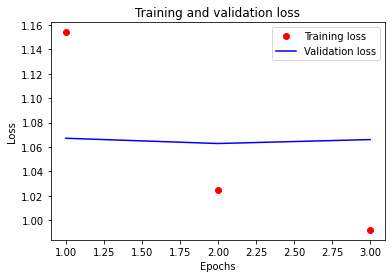

In [6]:
# Visualize the training and validation loss

history_dict = history.history
loss_values = history_dict['loss']
val_loss_values = history_dict['val_loss']
epochs = range(1, len(loss_values) + 1)

plt.plot(epochs, loss_values, 'ro', label='Training loss')
plt.plot(epochs, val_loss_values, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

### (II). Compute RMSE Score

In [7]:
m = tf.keras.metrics.RootMeanSquaredError()
m.update_state(model.predict(X_test_array), y_test)
m.result().numpy()

1.0086962

## 6. Verdict for using Keras Recommender

From the above RMSE results (ranges from 97.28% to 106.36%) for 5 million worth of data, Keras is not one of the best 3 RMSE achieved as compared to the surprise library. 
\
Hence, recommendations will be provided for the best three RMSE attained are in << Netflix RS - Hilary (2 of 3) >>. 

## == END == 